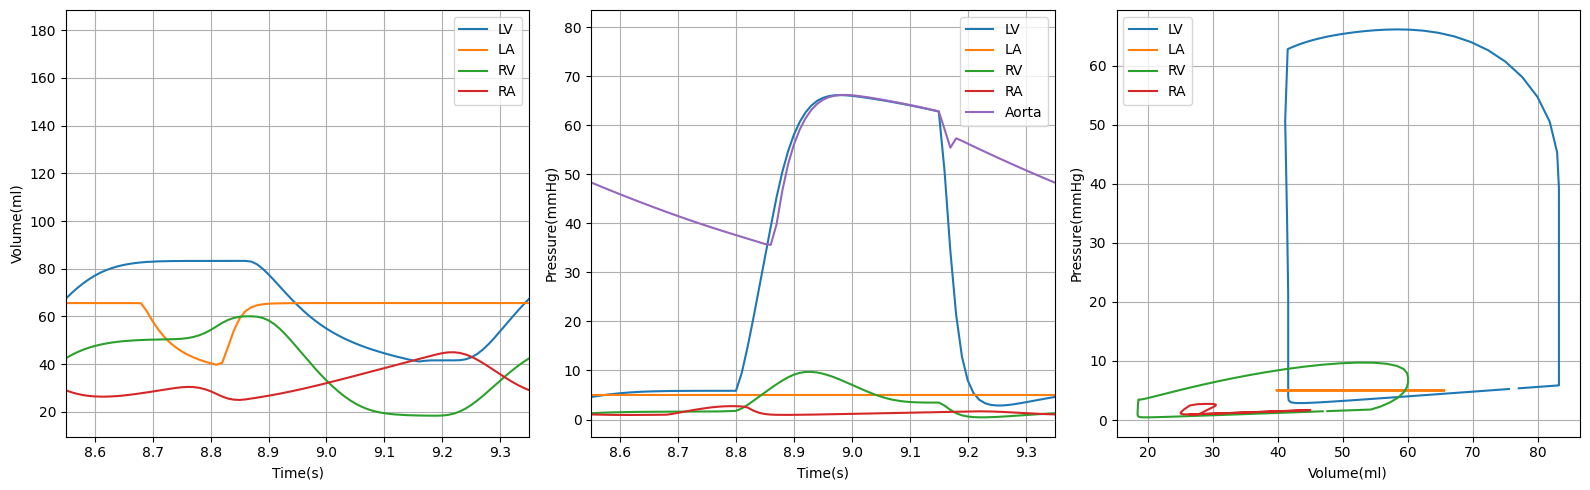

In [29]:
import numpy as np
import scipy as sp
import sympy
import math
import matplotlib.pyplot as plt
from closed_circuit import *
T=0.8
lv=heart(tau1 = 0.269*T, tau2 = 0.452*T, # tau1,2 (s)
         m1 = 1.32, m2 = 27.4, # m1,2
         Emax = 3,Emin = 0.08, # Emax,min (mmHg/mL)
        V0 = 10,T = T)# V0 (mL), T (s)

la=heart(tau1 = 0.110*T, tau2 = 0.180*T, #tau1,2
         m1 = 1.32,m2 = 13.1, # m1,2
         Emax = 0.17, Emin = 0.08, #Emax,min(mmHg/mL)
         V0 = 3,T = T) # V0 (mL), T (s)

av=ValveinP(density = 1.06, eff_length = 2.2,Aann = 5, # density, eff_length(cm), Aann
            Kvo = 0.12,Kvc = 0.15, # Kvo,Kvc
            p_oc = 0) #poc

mv=ValveinP(density = 1.06,eff_length =1.9,Aann = 5, # density, eff_length(cm), Aann
            Kvo = 0.3,Kvc = 0.4, # Kvo,Kvc
            p_oc = 0) #poc

#cap_s=PressureSystem(0.0008, 90, 700)#C,Za,R
cap_s=PressureSystem(0.0008, 90, 1200)

rv=heart(0.269*T,0.452*T, # tau1, 2
         1.32,27.4, # m1,2
         0.6,0.04, #Emax, min
         10,T) # Ks, V0 ,T

ra=heart(0.110*T,0.180*T, # tau1, 2
         1.32,13.1, # m1,2
         0.15,0.04, # Emax,min
         3, T) # Ks, V0, T

tv=ValveinP(1.06,2,6, # density, eff_length, Aann(cm2)
            0.3,0.4, # Kvo,Kvc
            0) #poc (mmHg)

pv=ValveinP(1.06,1.9,2.8, # density, eff_length, Aann(cm2)
            0.2,0.2, # Kvo,Kvc
            0) #poc

cap_p=PressureSystem(12.5,142.5,0.00875)#C,Za,R
t_end=10
t = [0,t_end]
t_span=np.arange(0,t_end,0.01)
aeff_av_values = []
et_lv = []
p_lv_values=[]
time=[]
def dydt(t,y):
    v_lv = y[0]
    v_la = y[1]
    q_av = y[2]
    q_mv = y[3]
    xi_av = y[4]
    xi_mv = y[5]
    #pressure of capillaries in systemic circulation
    pa = y[6]
    v_rv = y[7]
    v_ra = y[8]
    q_tv = y[9]
    q_pv = y[10]
    xi_tv = y[11]
    xi_pv = y[12]
    #pressure of capillaries in pulmonary circulation
    pb = y[13]
    
    #calculate parameters
    #systemic
    p_la = la.p(v_la,t,0.85*T)
    p_lv = lv.p(v_lv,t)
    #p_aa: pressure at the coupling point of av and capillaries
    p_aa = cap_s.pi(q_av,pa)
    #pulmonary
    p_ra = ra.p(v_ra,t,0.85*T)
    p_rv = rv.p(v_rv,t)
    #q_cap2: flow out the capillaries of pulmonary circulation
    q_cap2 = cap_p.qout(pb,p_la)
    #p_pa: pressure at the coupling point of pv and capillaries
    p_pa = cap_p.pi(q_tv,pb)
    #q_cap1: flow out the capillaries of systemic circulation
    q_cap1 = cap_s.qout(pa,p_ra)
    
    #derivative
    #la
    dv_la = la.dv(t,v_la,q_cap2,q_mv)
    dxi_mv = mv.dxi(t,xi_mv,p_la,p_lv)
    dq_mv = mv.dq(t,q_mv,xi_mv,p_la,p_lv)
    #lv
    dv_lv = lv.dv(t,v_lv,q_mv,q_av)
    dxi_av = av.dxi(t,xi_av,p_lv,p_aa)
    dq_av = av.dq(t,q_av,xi_av,p_lv,p_aa)
    #cap sys
    dpa = cap_s.dp_original(t,pa,q_av,p_ra)
    #ra
    dv_ra = ra.dv(t,v_ra,q_cap1,q_tv)
    dxi_tv = tv.dxi(t,xi_tv,p_ra,p_rv)
    dq_tv = tv.dq(t,q_tv,xi_tv,p_ra,p_rv)
    #rv
    dv_rv = rv.dv(t,v_rv,q_tv,q_pv)
    dxi_pv = pv.dxi(t,xi_pv,p_rv,p_pa)
    dq_pv = pv.dq(t,q_pv,xi_pv,p_rv,p_pa)
    #cap pul
    dpb = cap_p.dp_original(t,pb,q_pv,p_la)
    
    #derivative vector
    dy = np.array([dv_lv, dv_la, 
                   dq_av, dq_mv, 
                   dxi_av, dxi_mv, 
                   dpa, 
                   dv_rv, dv_ra, 
                   dq_tv, dq_pv, 
                   dxi_tv, dxi_pv, 
                   dpb])
    return dy

#initial condition
y_initial = np.array([135, 27, #lv, la
                      150, 10, #qav, qmv
                      0.01, 0.5, #xi_av, xi_mv
                      5*1333, #pa
                      180, 40, #v_rv, v_ra 
                      150, 10, #q_tv, q_pv
                      0.01, 0.5, #xi_tv, xi_pv
                      5*1333]) # pb

#integration
sol = sp.integrate.solve_ivp(dydt , t , y0 = y_initial , t_eval = t_span, method='LSODA')
v_lv = sol.y[0]
v_la = sol.y[1]
q_av = sol.y[2]
q_mv = sol.y[3]
xi_av = sol.y[4]
xi_mv = sol.y[5]
pa = sol.y[6]
v_rv = sol.y[7]
v_ra = sol.y[8]
q_tv = sol.y[9]
q_pv = sol.y[10]
xi_tv = sol.y[11]
xi_pv = sol.y[12]
pb = sol.y[13]
aeff_av = []
et_lv = []
B_av = []
p_lv_values = []
p_la_values = []
dp_av = []
L_av = []
dq_mv = []
dxi_mv = []
L_mv = []
B_mv = []
aeff_mv = []
dp_mv = []
dxi_av = []
et_la = []
dxi_tv = []
p_ra = []
p_rv = []
p_pa = []
dp_pv = []
p_aa = []
dxi_pv = []
dp_tv = []
q_cap2 = []
for i,j in zip(sol.t,range(len(sol.t))):
    aeff_av.append(av.Aeff(i, xi_av[j]))
    et_lv.append(lv.Et(i))
    et_la.append(la.Et(i,0.85*T))
    B_av.append(av.B(i, xi_av[j]))
    L_av.append(av.L(i, xi_av[j]))
    p_lv_values.append(lv.p(v_lv[j], i))
    p_la_values.append(la.p(v_la[j], i, 0.85*T))
    p_aa.append(cap_s.pi(q_av[j],pa[j]))
    q_cap2.append(cap_p.qout(pb[j],p_la_values[j]))
    dp_av.append(p_lv_values[-1]-p_aa[-1])
    
    dq_mv.append(mv.dq(i,q_mv[j],xi_mv[j],p_la_values[-1],p_lv_values[-1]))#time,q,xi,pin,pout
    dxi_mv.append(mv.dxi(i,xi_mv[j],p_la_values[-1],p_lv_values[-1]))
    L_mv.append(mv.L(i, xi_mv[j]))
    B_mv.append(mv.L(i, xi_mv[j]))
    aeff_mv.append(mv.Aeff(i, xi_mv[j]))
    dp_mv.append(p_la_values[-1]-p_lv_values[-1])
    dxi_av.append(av.dxi(i,xi_av[j],p_lv_values[j], cap_s.pi(q_av[j], pa[j])))
    
    p_ra.append(ra.p(v_ra[j],i, 0.85*ra.T))
    p_rv.append(rv.p(v_rv[j],i))
    dxi_tv.append(tv.dxi(i,xi_tv[j],p_ra[-1],p_rv[-1]))
    
    p_pa.append(cap_p.pi(q_pv[j],pb[j]))
    dxi_pv.append(pv.dxi(i,xi_pv[j],p_rv[-1],p_pa[-1]))
    
    dp_pv.append(p_rv[-1]-p_pa[-1])
    dp_tv.append(p_ra[-1]-p_rv[-1])
p_lv = list(map(lambda x: x / 1333, p_lv_values))
p_la = list(map(lambda x: x / 1333, p_la_values))
p_ao = list(map(lambda x: x / 1333, p_aa))
p_ra1 = list(map(lambda x: x / 1333, p_ra))
p_rv1 = list(map(lambda x: x / 1333, p_rv))
p_pul = list(map(lambda x: x/1333, p_pa))
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(16,5))
ax1.plot(sol.t, sol.y[0], label='LV')
ax1.plot(sol.t, sol.y[1], label='LA')
ax1.plot(sol.t, sol.y[7], label='RV')
ax1.plot(sol.t, sol.y[8], label='RA')
ax1.set_ylabel('Volume(ml)')
ax1.legend()
ax1.grid()
ax1.set_xlim(8.55,9.35) 
ax1.set_xlabel('Time(s)')

ax2.plot(sol.t, p_lv, label='LV')
ax2.plot(sol.t, p_la, label='LA')
ax2.plot(sol.t, p_rv1, label = 'RV')
ax2.plot(sol.t, p_ra1, label = 'RA')
ax2.plot(sol.t, p_ao, label='Aorta')
#ax2.plot(sol.t, p_pul, label = 'PA')
ax2.set_ylabel('Pressure(mmHg)')
ax2.legend()
ax2.grid()
ax2.set_xlim(8.55,9.35) 
ax2.set_xlabel('Time(s)')

#ax3.plot(sol.t, sol.y[4], label=r'$\xi_{AV}$')
#ax3.plot(sol.t, sol.y[5], label=r'$\xi_{MV}$')
#ax3.plot(sol.t, sol.y[11], label=r'$\xi_{TV}$')
#ax3.plot(sol.t, sol.y[12], label=r'$\xi_{PV}$')
#ax3.set_ylabel(r'$\xi$')
#ax3.legend()
#ax3.grid()
#ax3.set_xlim(41.33,41.91) 
#ax3.set_xlabel('Time(s)')


ax3.plot(sol.y[0][860:940], p_lv[860:940], label='LV')
ax3.plot(sol.y[1][860:940], p_la[860:940], label='LA')
ax3.plot(sol.y[7][860:940], p_rv1[860:940], label='RV')
ax3.plot(sol.y[8][860:940], p_ra1[860:940], label='RA')
ax3.set_ylabel('Pressure(mmHg)')
ax3.legend()
ax3.grid()
ax3.set_xlabel('Volume(ml)')


plt.tight_layout()
plt.savefig('two_heart_model.svg', format='svg')
plt.show()

In [18]:
max_volume_rv = max(sol.y[7][880:980])
min_volume_rv = min(sol.y[7][880:980])
sv_rv = max_volume_rv - min_volume_rv
rvef = sv_rv / max_volume_rv
max_volume_lv = max(sol.y[0][880:980])
min_volume_lv = min(sol.y[0][880:980])
sv_lv = max_volume_lv - min_volume_lv
lvef = sv_lv / max_volume_lv

In [19]:
print(lvef)
print(rvef)
print(sv_lv)
print(sv_rv)

0.6258732900547449
0.6073061238363949
70.04433208179788
70.03613361349801


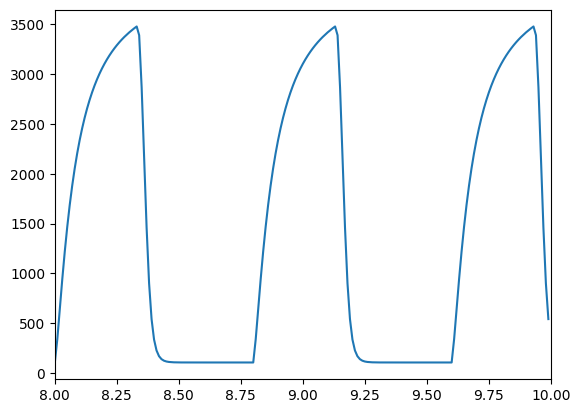

In [33]:
lv=heart(tau1 = 0.1*T, tau2 = 0.452*T, # tau1,2 (s)
         m1 = 1.32, m2 = 27.4, # m1,2
         Emax = 3,Emin = 0.08, # Emax,min (mmHg/mL)
        V0 = 10,T = T)# V0 (mL), T (s)
e = []
for i in sol.t:
    e.append(lv.Et(i))
plt.plot(sol.t, e)
plt.xlim(8,10)
plt.show()